# Naive bayes

# Loading data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from imblearn.over_sampling import SMOTE

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('../input/amazon-fine-food-reviews/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# [1] Text Preprocessing
## [1.1] Data Cleaning: Deduplication

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## [1.2] Stemming, stop-word removal and Lemmatization.

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'few', 'haven', 'yours', 'we', 'you', 'only', "you're", 'after', 'isn', 'him', 'that', 'just', "didn't", 'me', "aren't", "hadn't", 've', 'hers', 'own', 'the', 'below', 'she', 'i', 'ma', 'or', 'until', 'for', "won't", 'during', 'out', 'to', 'doing', 'yourself', 'its', 'didn', "hasn't", 'am', "shouldn't", 'but', 'weren', "isn't", 'then', 'both', 'their', 'in', 'aren', "needn't", 'between', 'his', 'above', 'all', 'while', 'of', 'such', 'm', 'wouldn', 'her', 'under', "wasn't", 'very', 's', 'doesn', 'having', 'did', 'themselves', 'needn', 'herself', 'won', 'your', 'being', "mustn't", 'any', 'be', 'each', 'down', 'against', "she's", "that'll", 'when', 'hasn', 'there', 'ourselves', 'same', 'should', 'up', 'some', 'ours', 'with', 'wasn', 'once', "shan't", 'why', "couldn't", 'not', 'd', 'they', 'my', 'itself', "you'd", "don't", 'at', 'y', 'is', "it's", 'can', "doesn't", 'it', 'off', 'll', 'ain', 'couldn', 'here', 'mightn', 'yourselves', 'shouldn', "wouldn't", 't', 're', 'again', 'shan', 'if', 

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

100%|██████████| 364171/364171 [08:28<00:00, 715.60it/s] 


In [13]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [14]:
final.to_pickle("./amazon.pkl")

In [15]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [16]:
# read data from pickle file from previous stage
data = pd.read_pickle("./amazon.pkl")

In [17]:
data.shape

(364171, 12)

# [2] Sorting data based on time

In [18]:
data['Time'] = pd.to_datetime(data['Time'])
# Sort by time
data = data.sort_values(by='Time')

print(data.shape)
print(data['Score'].value_counts())

(364171, 12)
1    307061
0     57110
Name: Score, dtype: int64


# [3] Spliting into train and test based on time (70:30)

In [19]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,shuffle=False)


# [4] Bag of Words (BoW)

In [20]:
#Bag of words
count_vect = CountVectorizer(max_features=2000, min_df=10) 

X_train = count_vect.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

X_test = count_vect.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (254919, 2000)
Test Data Size:  (109252, 2000)


## [4.1] Bernoulli naive bayes

In [21]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV

bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))


Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best HyperParameter:  {'alpha': 0.01}
Best Accuracy: 88.72%


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   26.4s finished


In [22]:
# This function plots the confusion matrices
def plot_confusion_matrix(y_test, y_pred):
    C = confusion_matrix(y_test, y_pred)       
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [0,1]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(8,4))
    sns.heatmap(C, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(8,4))
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(8,4))
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Accuracy on test set: 87.848%
Precision on test set: 0.930
Recall on test set: 0.922
F1-Score on test set: 0.926
-------------------- Confusion matrix --------------------


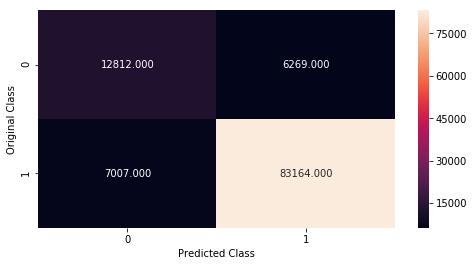

-------------------- Precision matrix (Columm Sum=1) --------------------


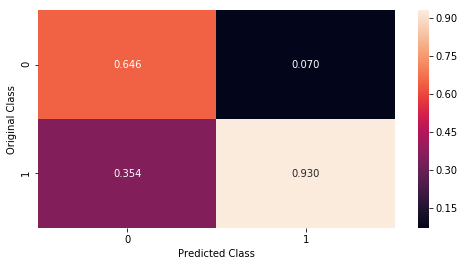

-------------------- Recall matrix (Row sum=1) --------------------


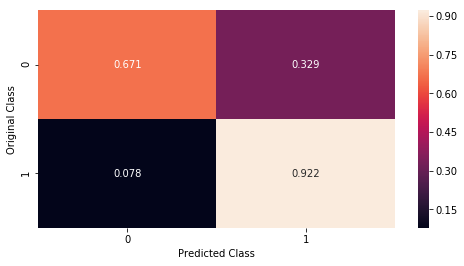

In [23]:
#Testing Accuracy on Test data
bnb = BernoulliNB(alpha=0.01)
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [4.2] Multinomial Naive Bayes

In [24]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
params = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
tscv = TimeSeriesSplit(n_splits = 10)
gscv = GridSearchCV(mnb, params, cv = tscv)

gscv.fit(X_train, y_train)

print("Best Hyperparameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Best Hyperparameter:  {'alpha': 0.01}
Best Accuracy: 86.34%


Accuracy on test set: 85.009%
Precision on test set: 0.847
Recall on test set: 0.998
F1-Score on test set: 0.917
-------------------- Confusion matrix --------------------


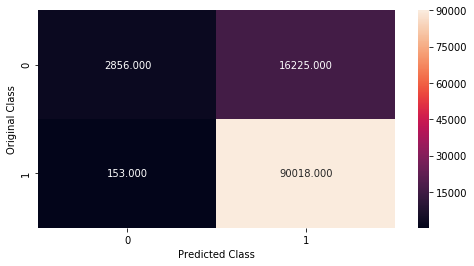

-------------------- Precision matrix (Columm Sum=1) --------------------


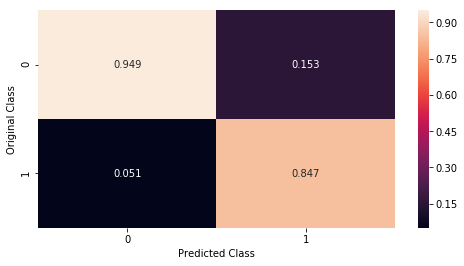

-------------------- Recall matrix (Row sum=1) --------------------


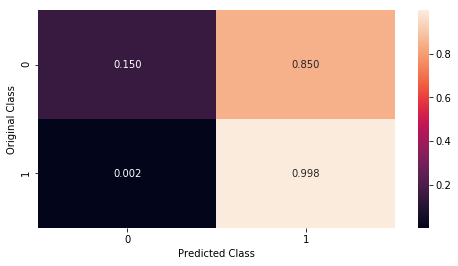

In [25]:
# Accuracy on testing data

mnb = MultinomialNB(alpha = 0.01)
mnb.fit(X_train, y_train)

y_pred = mnb.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [4.3] Feature Importance

In [29]:
def features_importance(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("Positive\t\t\t\t\tNegative")
    print("-"*100)
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
features_importance(count_vect,bnb)

Positive					Negative
----------------------------------------------------------------------------------------------------
-7.4588	moth           				-1.1898	like           
-7.1933	mole           				-1.2078	tast           
-7.1396	yuck           				-1.2728	love           
-6.9888	zico           				-1.2770	good           
-6.9448	grit           				-1.2940	great          
-6.9448	mislead        				-1.4290	flavor         
-6.9400	rope           				-1.4724	one            
-6.8935	clam           				-1.4907	use            
-6.8799	miso           				-1.5344	tri            
-6.8799	rancid         				-1.5642	product        
-6.8755	rabbit         				-1.6464	make           
-6.8534	bpa            				-1.6961	get            
-6.8023	bulli          				-1.9062	buy            
-6.8023	trash          				-1.9097	time           
-6.7777	velveeta       				-1.9481	amazon         
-6.7577	chia           				-1.9581	would          
-6.7458	refund         				-1.9585	best           
-6.7264	mo

# [5] TF-IDF

In [30]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,shuffle=False)

In [31]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=2000, min_df=10) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (254919, 2000)
Test Data Size:  (109252, 2000)


## [5.1] Bernoulli naive bayes

In [32]:
bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,7,6,5,4,2,1,0.5,0.1,0.05,0.01,0.005,0.001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 17 candidates, totalling 170 fits
Best HyperParameter:  {'alpha': 0.001}
Best Accuracy: 89.00%


[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:   33.2s finished


Accuracy on test set: 88.204%
Precision on test set: 0.937
Recall on test set: 0.919
F1-Score on test set: 0.928
-------------------- Confusion matrix --------------------


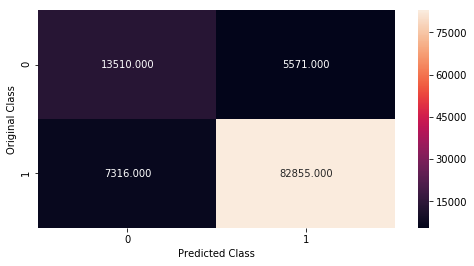

-------------------- Precision matrix (Columm Sum=1) --------------------


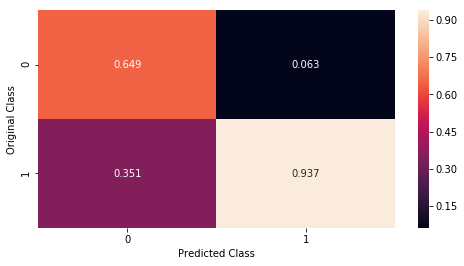

-------------------- Recall matrix (Row sum=1) --------------------


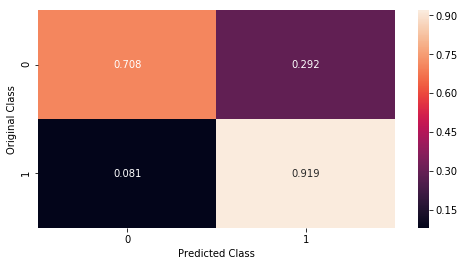

In [33]:
#Testing Accuracy on Test data

bnb = BernoulliNB(alpha=0.001)
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [5.2] Bernoulli naive bayes

In [34]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
params = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
tscv = TimeSeriesSplit(n_splits = 10)
gscv = GridSearchCV(mnb, params, cv = tscv)

gscv.fit(X_train, y_train)

print("Best Hyperparameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Best Hyperparameter:  {'alpha': 0.001}
Best Accuracy: 87.39%


Accuracy on test set: 86.347%
Precision on test set: 0.860
Recall on test set: 0.996
F1-Score on test set: 0.923
-------------------- Confusion matrix --------------------


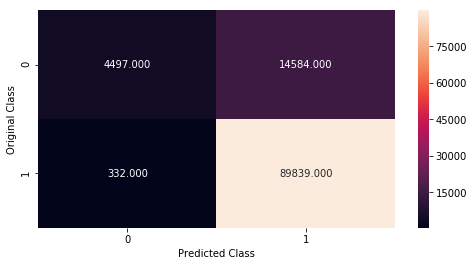

-------------------- Precision matrix (Columm Sum=1) --------------------


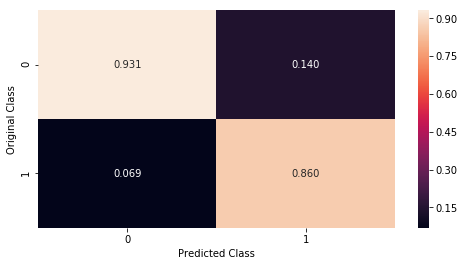

-------------------- Recall matrix (Row sum=1) --------------------


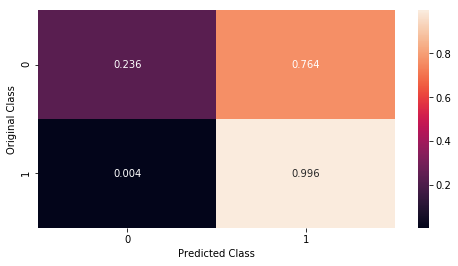

In [35]:
#Testing Accuracy on Test data

mnb = MultinomialNB(alpha=0.001)
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [5.3] Feature Importance

In [36]:
def features_importance(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("Positive\t\t\t\t\tNegative")
    print("-"*100)
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
features_importance(tfidf,bnb)

Positive					Negative
----------------------------------------------------------------------------------------------------
-6.9938	wast money     				-1.1898	like           
-6.9544	wont buy       				-1.2078	tast           
-6.8023	trash          				-1.2728	love           
-6.7459	refund         				-1.2770	good           
-6.7112	never buy      				-1.2940	great          
-6.5900	tasteless      				-1.4290	flavor         
-6.4820	garbag         				-1.4724	one            
-6.4321	vomit          				-1.4907	use            
-6.4321	worst          				-1.5344	tri            
-6.4264	mate           				-1.5642	product        
-6.4235	buyer          				-1.6464	make           
-6.4235	disgust        				-1.6961	get            
-6.3983	threw          				-1.9062	buy            
-6.3629	rooibo         				-1.9097	time           
-6.3602	oreo           				-1.9481	amazon         
-6.3576	fli            				-1.9581	would          
-6.3549	tazo           				-1.9585	best           
-6.3313	un

# [6] Performance Table

# ![image](https://i.ibb.co/YTGLBkh/Untitled.png)

# Obseration